In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2017)

In this notebook, we'll implement the distributed version of the Affinity Propagation Clustering Algorithm.

Let's begin by testing Spark and checking everything is ok before proceeding... This example will be deleted later.
An interesting link is the following: http://blog.cloudera.com/blog/2014/09/how-to-translate-from-mapreduce-to-apache-spark/

Let's begin be implementing a word count example using Spark and mimicking Map/Reduce paradigm. We'll adapt this code to our problem later.

In [2]:
# SparkContext is automatically created in the object named "sc"

# Read the text file
text_file = sc.textFile("Les_Miserables.txt")

# Split the text into words
tokenized = text_file.flatMap(lambda line: line.split(" "))

# Mapper part: Associate the weight 1 to each word
wordCountsMapper = tokenized.map(lambda word: (word, 1))

# Reducer part: Count the words occurences by grouping by key
wordCountsReducer = wordCountsMapper.reduceByKey(lambda v1, v2: v1 + v2)

# Display the counts
print(wordCountsReducer.collect())

[('', 21030), ('Duprat,', 1), ('_non', 1), ('Just', 29), ('spectators.', 4), ('creep."', 1), ('divers', 11), ('rustle,', 1), ('Romance', 2), ('coats"', 1), ('1821,', 2), ('rare,', 6), ('mobile', 1), ('withering', 1), ('twice,', 4), ('Precipices', 1), ('vastness', 1), ('eating,', 3), ('escape,', 12), ('inactive', 1), ('boot-stitcher', 1), ('FOREST', 2), ('Ruysdael', 1), ('fish-market;', 1), ('why', 64), ('circle', 17), ('preceding', 60), ('creole.', 1), ("d'Am*****,", 1), ('singing', 19), ('rut;', 1), ('_9th', 1), ('blackening', 1), ('Everywhere,', 1), ('cavities', 2), ('like?"', 2), ('pleased,', 2), ('Revolt,', 2), ('sub-diaconate.', 1), ('frock,', 1), ('humility.', 1), ('errors', 4), ('Abbey,', 1), ('China.', 2), ('curtains.', 3), ('Monsieur,"', 1), ('Barcelonette.', 1), ('dread', 1), ('erect.', 3), ('_Volaverunt_.', 1), ('_Thérèse', 1), ('inscription', 5), ('hiccough', 2), ('payment.', 1), ('younger;', 1), ('Æschylus.', 1), ('exercise,', 1), ('reducible,', 1), ('latitudes', 1), ('cla

Actual Affinity propagation Clustering algorithm :

The following class defines a mapper for the Affinity Propagation Clustering Algorithm.

In [3]:
class Mapper:
    """
    This class defines a mapper object that computes the partial centroids for the partial dataset given in arguments.
    """
    
    def __init__(self, data):
        """
        This is the class' constructor.
        """
        
        # Dataset
        self.__data = data
        
        # Number of samples in the dataset
        self.__N = data.shape[0]
        
        # Availabilities matrix
        self.__A = np.zeros((self.__N, self.__N))
        
        # Responsabilities matrix
        self.__R = np.zeros((self.__N, self.__N))
        
        # Similarity matrix
        self.__S = np.zeros((self.__N, self.__N))
        
        # List of centroids
        self.__centers = []
    
    def __a(self, i, k):
        """
        This method computes the availability sent from point i to point k.
        
        Parameters
        ----------
        i : integer
                This is the index i needed to select the first point.

        k : integer
                This is the index k needed to select the first point.

        Returns
        -------
        a : float
                This is the availability of point i for k.
        """

        if i != k:
            a = min([0, self.__R[k, k] + sum([max(0, self.__R[i_prime, k]) for i_prime in range(self.__N) if i_prime != i and i_prime != k])])
        else:
            a = sum([max(0, self.__R[i_prime, k]) for i_prime in range(self.__N) if i_prime != k])
            
        return a

    def __r(self, i, k):
        """
        This method computes the responsability sent from point i to point k.
        
        Parameters
        ----------
        i : integer
                This is the index i needed to select the first point.

        k : integer
                This is the index k needed to select the first point.

        Returns
        -------
        r : float
                This is the responsability of point i for k.
        """

        r = self.__S[i, k] - max([self.__A[i, k_prime] + self.__S[i, k_prime] for k_prime in range(self.__N) if k_prime != k])
        return r

    def __s(self, x_i, x_k):
        """
        This method computes the similarity between two points (negative squared error).
        
        Parameters
        ----------
        x_i : numpy array
                This is the ith point of the dataset.

        x_k : numpy array
                This is the kth point of the dataset.

        Returns
        -------
        s : float
                This is the similarity between points i and k.
        """

        s = -np.sum((x_i - x_k) ** 2)
        return s

    def __GenerateSimilarityMatrix(self):
        """
        This method generates the similarity matrix for all the points given to the mapper.
        
        Parameters
        ----------
        None

        Returns
        -------
        None
        """

        # As the matrix is symetric, we don't compute the similarity for each couple
        for r in range(self.__N): # For each row
            for c in range(r + 1, self.__N): # For each column
                tmp = self.__s(self.__data[r], self.__data[c])
                self.__S[r, c] = tmp
                self.__S[c, r] = tmp

        # For diagonal: compute "preferences"
        flatS = self.__S.flatten()
        for i in range(self.__N):
            self.__S[i, i] = np.median(flatS[flatS != 0.0])
                            
    def ExecuteAffinityPropagation(self, iterations, lambdaValue = 0.5):
        """
        This method executes the Affinity Propagation algorithm on several iterations.
        
        Parameters
        ----------
        iterations : positive integer
                This is the number of iterations the algorithm will be executed.

        lambdaValue : float
                This is the lambda specified in the paper.

        Returns
        -------
        self.__centers : list
                This list contains all the centroids computed by the algorithm.
        """
        
        # Compute the similarity matrix
        self.__GenerateSimilarityMatrix()

        for i in range(iterations):
            # Update r(i, k) given a(i, k)
            for i in range(self.__N): # For each row
                for k in range(self.__N): # For each column
                    self.__R[i, k] = (1 - lambdaValue) * self.__r(i, k) + lambdaValue * self.__R[i, k]

            # Update a(i, k) given r(i, k)
            for i in range(self.__N): # For each row
                for k in range(self.__N): # For each column
                    self.__A[i, k] = (1 - lambdaValue) * self.__a(i, k) + lambdaValue * self.__A[i, k]

            # Combine both a(i, k) and r(i, k) to get centers
            self.__centers = [i for i in range(self.__N) if self.__R[i, i] + self.__A[i, i] > 0]
            
        return self.__centers

Let's use the class into Spark.

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Create a SparkSession # Only for Spark 2
spark = SparkSession.builder.appName("Affinity Propagation algorithm").getOrCreate()
    
# Read the data
irisData = spark.read.option("header","true").csv("iris_species.csv")

# Only keep useful columns
irisData = irisData.select("SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm")

# Make sure we've the right data type
irisData = irisData.withColumn("SepalLengthCm", irisData["SepalLengthCm"].cast("double"))
irisData = irisData.withColumn("SepalWidthCm", irisData["SepalWidthCm"].cast("double"))
irisData = irisData.withColumn("PetalLengthCm", irisData["PetalLengthCm"].cast("double"))
irisData = irisData.withColumn("PetalWidthCm", irisData["PetalWidthCm"].cast("double"))

Let's see how is our data:

In [5]:
irisData.printSchema()

root
 |-- SepalLengthCm: double (nullable = true)
 |-- SepalWidthCm: double (nullable = true)
 |-- PetalLengthCm: double (nullable = true)
 |-- PetalWidthCm: double (nullable = true)



Let's see how many samples we have.

In [6]:
irisData.count()

150

We'll now split the dataframe to feed several mappers.

In [7]:
splittedDataframe = irisData.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2]) # We do 5 splits with 20% data in each150*.2

Let's plot the sepal length and width for the first split.

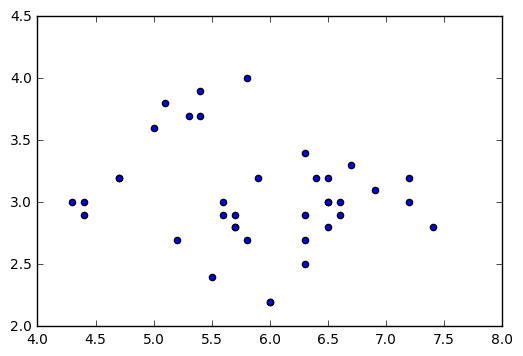

In [8]:
plotData = splittedDataframe[0].select("SepalLengthCm", "SepalWidthCm").toPandas()
plt.scatter(plotData["SepalLengthCm"], plotData["SepalWidthCm"])
plt.show()

Now, let's map each data frame to a mapper.

In [81]:
splittedDataframe[0].map(lambda item: print(item))

AttributeError: 'DataFrame' object has no attribute 'map'

In [20]:
# Temporary cell. To be deleted later

N = 10
x_1 = np.random.multivariate_normal(mean = [0,0], cov = [[0.1,0],[0,0.1]], size = N)
x_2 = np.random.multivariate_normal(mean = [3,0], cov = [[0.3,-0.1],[-0.1,0.2]], size = N)
x_3 = np.random.multivariate_normal(mean = [0,3], cov = [[0.2,0],[0,0.2]], size = N)
N = 3 * N
X = np.concatenate((x_1, x_2, x_3))

plt.scatter(X[:,0], X[:,1])
plt.show()

m1 = Mapper(X)
m1Centroids = m1.ExecuteAffinityPropagation(100)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X[:, 0], X[:, 1], s = 10, c = 'b', marker = "s", label = 'data')
ax1.scatter(X[m1Centroids, 0], X[m1Centroids, 1], s = 30, c = 'r', marker = "o", label = 'centroids')
plt.legend(loc = 'upper right');
plt.show()